In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pandas.plotting import register_matplotlib_converters
import numpy as np
sns.set_style('darkgrid')
register_matplotlib_converters()
# matplotlib 環境設定，讓matplotlib可以顯示中文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

# get the data from csv
data_path = glob.glob("../../**/VegPirceTracking/single_market_data.csv", recursive=True)[0]
df = pd.read_csv(data_path)

df.head()

品名代號    品名   品種  平均價(元/公斤)  成交量(公斤)     上價    中價    下價         日期
0   FA0  其他花類  NaN       83.5       26   90.0  88.6  62.0  110/10/20
1   FA1   黃秋葵  NaN       84.2     2071  117.4  83.5  53.0  110/10/20
2  FB11   花椰菜   青梗       57.1     5631  104.5  51.6  26.3  110/10/20
3   FC1    胡瓜   黑刺       27.6    12222   43.4  26.7  14.5  110/10/20
4   FD0   花胡瓜   其他       84.6      405  126.5  77.7  63.5  110/10/20

In [2]:
# Clean up the data
# Replace nan in variety
df['品種'] = df['品種'].replace(np.nan, '單一品種')
df['品名'] = df['品名'].replace('蕃茄','番茄')
# print(len(df['品名'].unique()))

In [3]:
# Convert messy date into datetime object
df[['Year','date_']] = df['日期'].astype('str').str.split('/', n=1, expand=True)
df['Year'] = df['Year'].astype('int') + 1911
df['Date'] = (df['Year'].astype('str') +'/'+ df['date_']).astype('datetime64[ns]')
df.drop(columns=['日期', 'Year', 'date_'], inplace = True)

print(df.head())

   品名代號    品名    品種  平均價(元/公斤)  成交量(公斤)     上價    中價    下價       Date
0   FA0  其他花類  單一品種       83.5       26   90.0  88.6  62.0 2021-10-20
1   FA1   黃秋葵  單一品種       84.2     2071  117.4  83.5  53.0 2021-10-20
2  FB11   花椰菜    青梗       57.1     5631  104.5  51.6  26.3 2021-10-20
3   FC1    胡瓜    黑刺       27.6    12222   43.4  26.7  14.5 2021-10-20
4   FD0   花胡瓜    其他       84.6      405  126.5  77.7  63.5 2021-10-20


In [4]:
# Add column wholename = name (variety)
df['全名'] = df['品名'] + "(" + df['品種'] + ")"

# Make a dict for getting whole name from code
name_dict = pd.Series(df['全名'].values,index=df['品名代號']).to_dict()

# how many days of data we have
total_duration = (df['Date'].max()-df['Date'].min()).days

# 交易次數
df_temp = df.groupby('全名').count().sort_values('品名代號', ascending = True)
df_temp.loc[:, 'frequency'] = df_temp['Date']/ total_duration
df_temp = df_temp[df_temp['frequency'] > 0.25] # Sold quater of a year
frequent_traded = list(df_temp.index)

df = df[df['全名'].isin(frequent_traded)]

print('All veggie: {} kinds, veggie that trade 3 quaters of a year: {} kinds'.format(len(df['全名'].unique()), len(df_temp.index)))


All veggie: 266 kinds, veggie that trade 3 quaters of a year: 266 kinds


In [5]:
# # Feel the data
# list_of_least_traded = list(df.groupby('品名').mean().sort_values(by='成交量(公斤)', ascending=True).index[0:33])
# df.drop(df[df['品名'].isin(list_of_least_traded)].index, inplace=True)

In [6]:
print(df.dtypes)

品名代號                 object
品名                   object
品種                   object
平均價(元/公斤)           float64
成交量(公斤)               int64
上價                  float64
中價                  float64
下價                  float64
Date         datetime64[ns]
全名                   object
dtype: object


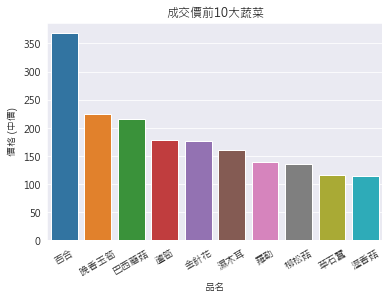

In [7]:
# Top 10 expensive veggies
temp_df = df.groupby('品名').mean().sort_values('中價', ascending = False).head(10)
sns.barplot(x = temp_df.index, y = '中價', data = temp_df)
plt.xlabel('品名')
plt.ylabel('價格 (中價)')
plt.title('成交價前10大蔬菜')
plt.xticks(rotation=30)
plt.show()

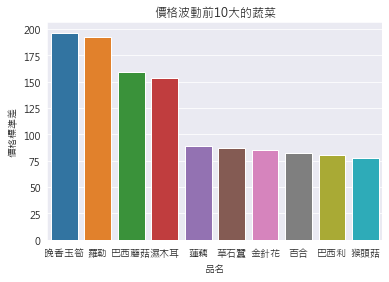

In [8]:
# 10 veggies with the most varying prices
temp_df = df.groupby('品名').std().sort_values('中價', ascending = False).head(10)
sns.barplot(x = temp_df.index, y = '中價', data = temp_df)
plt.ylabel('價格標準差')
plt.title('價格波動前10大的蔬菜')
plt.show()

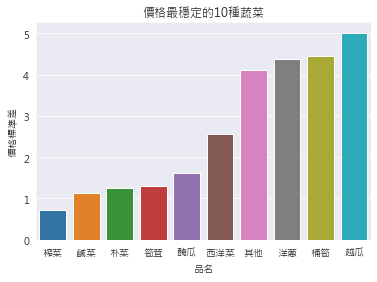

In [9]:
# 10 veggies with the most steady prices
temp_df = df.groupby('品名').std().sort_values('中價', ascending = True).head(10)
sns.barplot(x = temp_df.index, y = '中價', data = temp_df)
plt.ylabel('價格標準差')
plt.title('價格最穩定的10種蔬菜')
plt.show()

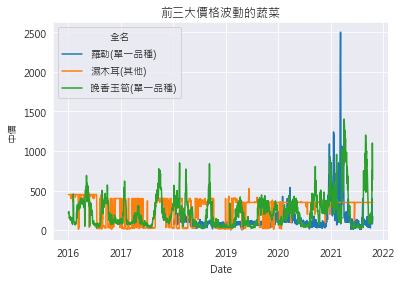

In [10]:
top_3_var = list(df.groupby('全名').std().sort_values('中價', ascending = False).index[0:3]) # find out the top 3 varitety with highest varying price

df_temp = df[df['全名'].isin(top_3_var)] # filter out the top 3 varitety with highest varying price

plot1 = sns.lineplot(x= 'Date', y='中價', hue= '全名', data = df_temp)
plt.title('前三大價格波動的蔬菜')
plt.show()
# df_temp

/Users/yichenshih/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/yichenshih/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


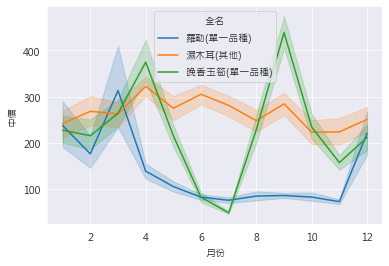

In [11]:
df1 = df[df.loc[:,'全名'].isin(top_3_var)]
df1.loc[:, '月份'] = pd.DatetimeIndex(df1['Date']).month
# temp_df = df1.groupby(['品名','月份']).mean()
# temp_df = df1.groupby(['品名',pd.Grouper(freq='M', key='Date')]).mean()
sns.lineplot(x = '月份', y = '中價', data = df1, hue = '全名')
plt.show()


平均價(元/公斤)        成交量(公斤)          上價         中價         下價  \
全名                                                                      
甘藍(初秋)     22.080958  128793.894403   29.437853  22.171495  14.481131   
番茄(牛番茄)    43.862918   31898.216840   65.112226  43.508651  23.674856   
甘藍(改良種)    16.833560   59052.518266   22.385944  16.919133  11.034799   
青蔥(粉蔥)     61.696655   21490.127451   78.460727  61.787832  44.654902   
花胡瓜(單一品種)  38.754325   27247.074394   54.686275  38.787774  22.711707   
敏豆(白豆)     89.188235    9267.336217  137.470358  89.086275  41.206459   
絲瓜(單一品種)   28.358304   29062.952710   40.310554  28.077451  17.250750   
青花苔(單一品種)  37.998867   18812.858414   55.111893  37.643366  21.947006   
包心白菜(包白)   16.283391   42794.593426   24.998962  15.937255   8.618685   
菠菜(圓葉)     34.968514   22635.353562   46.741865  34.891909  23.423747   

                   交易總價  
全名                       
甘藍(初秋)     2.124998e+06  
番茄(牛番茄)    1.247985e+06  
甘藍(改良種)    1.096878e+06  
青蔥(粉蔥)     1.028218e+06  
花胡瓜(單一品種)  9.686066e+05  
敏豆(白豆)     7.518778e+05  
絲瓜(單一品種)   6.924204e+05  
青花苔(單一品種)  6.268717e+05  
包心白菜(包白)   6.209187e+05  
菠菜(圓葉)     5.752340e+05

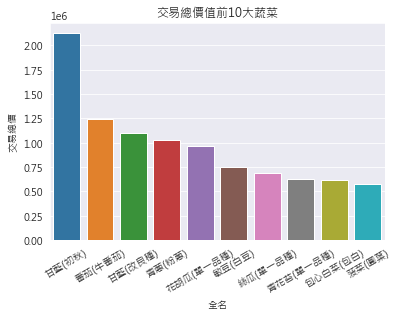

In [12]:
# 交易價值前10大
df.loc[:,'交易總價'] = df['平均價(元/公斤)'] * df['成交量(公斤)']
df_temp1 = df.groupby('全名').mean().sort_values(by='交易總價', ascending=False).head(10)
sns.barplot(x=df_temp1.index, y= '交易總價' , data = df_temp1)
plt.title('交易總價值前10大蔬菜')
plt.xticks(rotation=30)
df_temp1

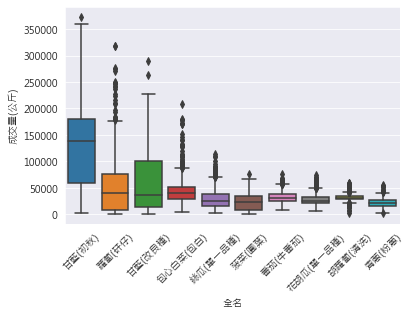

In [13]:
# whats the distribution of volume
# find out the top 10 varitety with highest volume
top_10_vol = list(df.groupby('全名').mean().sort_values('成交量(公斤)', ascending = False).index[0:10]) 

df_temp = df[df['全名'].isin(top_10_vol)].sort_values('成交量(公斤)', ascending = False) # filter out the top 10 varitety with highest volume

sns.boxplot(x='全名', y='成交量(公斤)', data=df_temp)
plt.xticks(rotation=45)
plt.show()


/Users/yichenshih/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/yichenshih/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
<ipython-input-14-42f711fdced0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

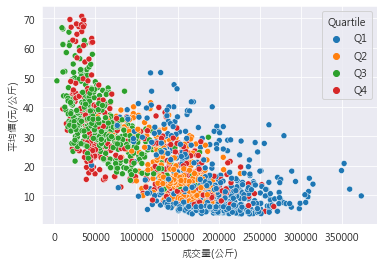

In [14]:
df_temp = df[df['全名'] == top_10_vol[0]]
labels = ["Q1", "Q2", "Q3", "Q4"]
df_temp.loc[:, '月份'] = pd.DatetimeIndex(df_temp['Date']).month
# df_temp.loc[:, '季'] = pd.PeriodIndex(df_temp['Date'], freq = "Q")
df_temp['Quartile'] = pd.qcut(df_temp['月份'], q=4, labels= labels)
sns.scatterplot(x='成交量(公斤)', y = '平均價(元/公斤)', data = df_temp, hue= 'Quartile')
plt.show()


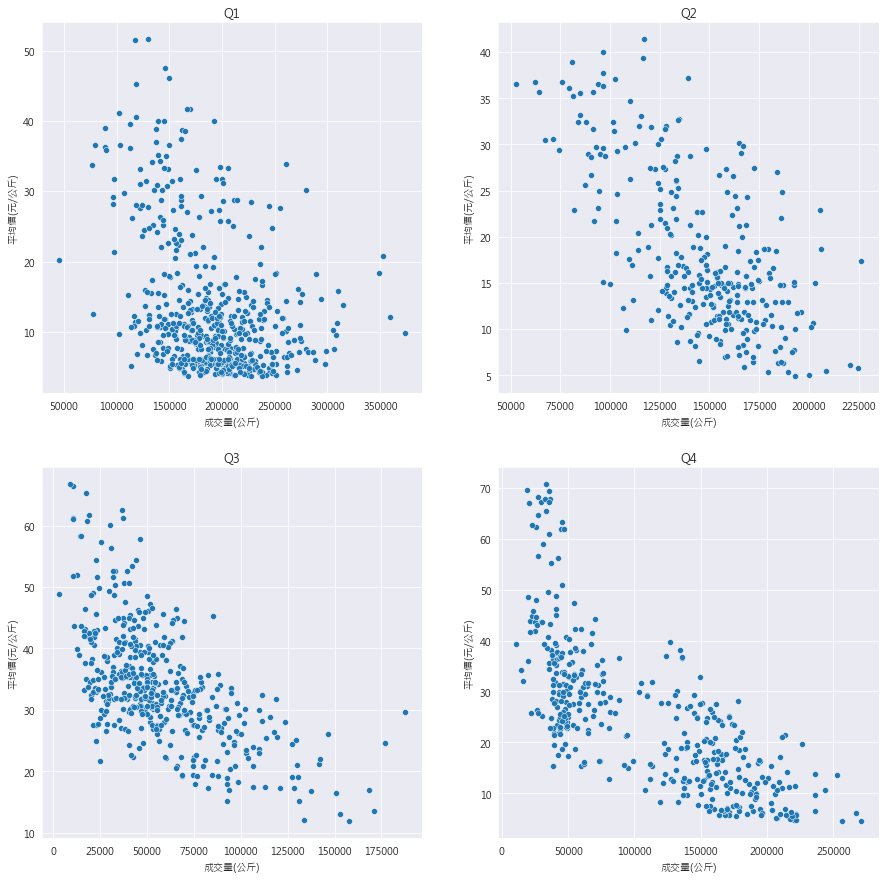

In [15]:

fig, axs = plt.subplots(2,2, figsize=(15,15))
sns.scatterplot(ax= axs[0,0], x='成交量(公斤)', y = '平均價(元/公斤)', data = df_temp[df_temp['Quartile']=="Q1"])
axs[0,0].set_title('Q1')
sns.scatterplot(ax= axs[0,1], x='成交量(公斤)', y = '平均價(元/公斤)', data = df_temp[df_temp['Quartile']=="Q2"])
axs[0,1].set_title('Q2')
sns.scatterplot(ax= axs[1,0], x='成交量(公斤)', y = '平均價(元/公斤)', data = df_temp[df_temp['Quartile']=="Q3"])
axs[1,0].set_title('Q3')
sns.scatterplot(ax= axs[1,1], x='成交量(公斤)', y = '平均價(元/公斤)', data = df_temp[df_temp['Quartile']=="Q4"])
axs[1,1].set_title('Q4')
plt.show()

In [22]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

x = np.asanyarray(df_temp[['成交量(公斤)']])
y = np.asanyarray(df_temp[['平均價(元/公斤)']])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

LP = LinearRegression().fit(x_train, y_train)
y_hat = LP.predict(x_test)
print("Residual sum of squares for train: %.2f"% np.mean((LP.predict(x_train) - y_train) ** 2))
print("Residual sum of squares for test: %.2f"% np.mean((y_hat - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % LP.score(x_test, y_test))



(1386, 1) (347, 1)
Residual sum of squares for train: 73.44
Residual sum of squares for test: 77.51
Variance score: 0.58
